In [1]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/00/5a/f43bad68b31269a72bdd66102732ea4473e98f421ee9f71379e35dcb56f5/xgboost-3.0.5-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/56.8 MB 656.4 kB/s eta 0:01:27
   ---------------------------------------- 0.2/56.8 MB 1.1 MB/s eta 0:00:50
   ---------------------------------------- 0.3/56.8 MB 1.8 MB/s eta 0:00:32
   ---------------------------------------- 0.5/56.8 MB 2.2 MB/s eta 0:00:26
   ---------------------------------------- 0.7/56.8 MB 2.6 MB/s eta 0:00:22
    --------------------------------------- 0.9/56.8 MB 2.7 MB/s eta 0:00:21
    --------------------------------------- 1.1/56.8 MB 3.0 MB/s eta 0:00:19
    --------------------------------------- 1.3/56.8 MB 3.2 MB/s eta 0:00:18
   - --------------------------------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE

In [4]:
data = pd.read_csv("fraud.csv")
print("shape:", data.shape)
data.head

shape: (6362620, 11)


<bound method NDFrame.head of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   
1  

In [5]:
data = data.drop(["nameOrig", "nameDest"], axis=1)
data = pd.get_dummies(data, columns=["type"], drop_first=True)

data["errorBalanceOrig"] = data["oldbalanceOrg"] - data["amount"] - data["newbalanceOrig"]
data["errorBalanceDest"] = data["newbalanceDest"] - data["oldbalanceDest"] - data["amount"]

print("shape after feature engineering:", data.shape)
data.head()

shape after feature engineering: (6362620, 14)


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,errorBalanceOrig,errorBalanceDest
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,False,False,True,False,0.0,-9839.64
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,False,False,True,False,0.0,-1864.28
2,1,181.00,181.0,0.00,0.0,0.0,1,0,False,False,False,True,0.0,-181.00
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,True,False,False,False,0.0,-21363.00
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,False,False,True,False,0.0,-11668.14


In [6]:
X= data.drop("isFraud", axis=1)
y = data["isFraud"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [7]:
neg, pos = np.bincount(y_train)
scale = neg / pos
print("Scale_pos_weight:", scale)

Scale_pos_weight: 773.7482496194825


In [8]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale,
    random_state=42,
    tree_method="hist",
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)

In [9]:
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:,1]

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   1270881
       Fraud       0.88      0.99      0.93      1643

    accuracy                           1.00   1272524
   macro avg       0.94      1.00      0.97   1272524
weighted avg       1.00      1.00      1.00   1272524



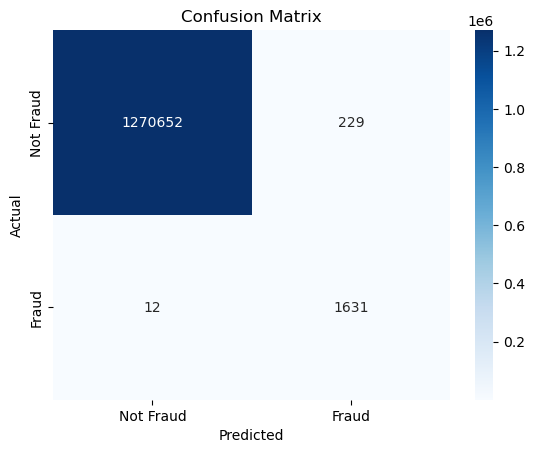

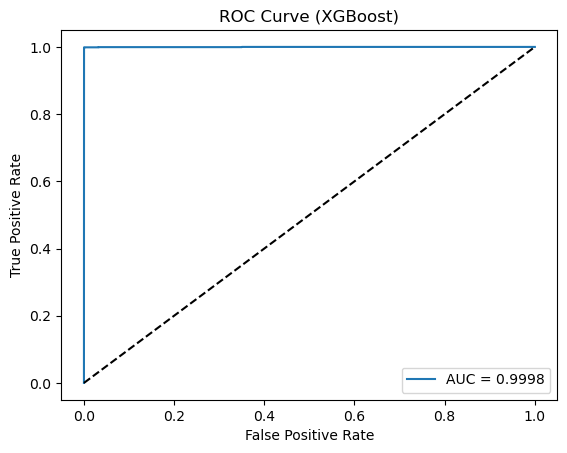

In [17]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Fraud", "Fraud"]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost)")
plt.legend()
plt.show()

In [20]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * precision * recall / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold:", best_threshold)
print("Best F1 score:", f1_scores[best_idx])

y_pred_adj = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_adj, target_names=["Not Fraud","Fraud"]))


Best threshold: 0.99479383
Best F1 score: 0.9593446596941794
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   1270881
       Fraud       0.96      0.96      0.96      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.98      0.98   1272524
weighted avg       1.00      1.00      1.00   1272524



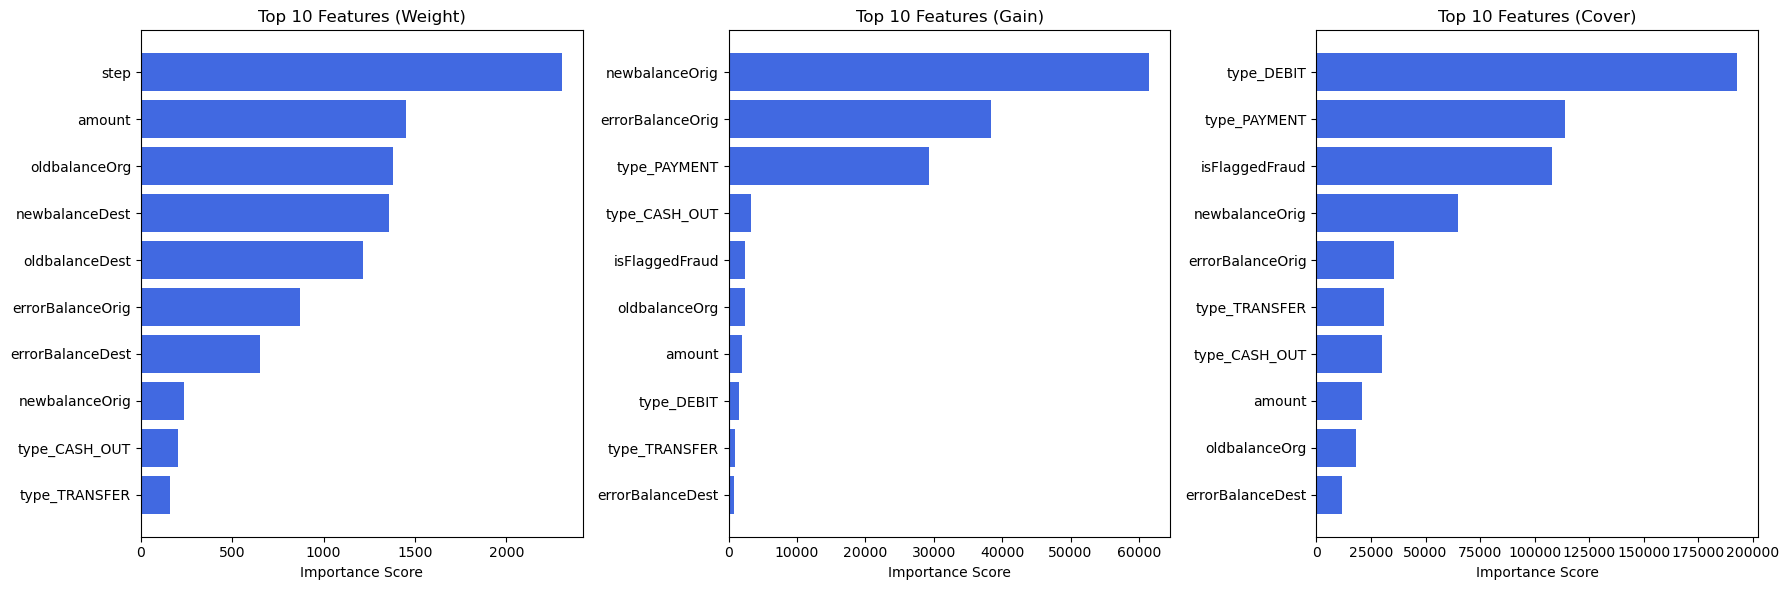

In [14]:
feature_names = [
    'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest',
    'isFlaggedFraud',
    'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
    'errorBalanceOrig', 'errorBalanceDest'
]

def get_importance(imp_type):
    booster = xgb_model.get_booster()
    importance_dict = booster.get_score(importance_type=imp_type)
    return pd.DataFrame({
        "Feature": [feature_names[int(f[1:])] for f in importance_dict.keys()],
        "Importance": list(importance_dict.values())
    }).sort_values(by="Importance", ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, imp_type in zip(axes, ["weight", "gain", "cover"]):
    df = get_importance(imp_type).head(10)  # top 10
    ax.barh(df["Feature"], df["Importance"], color="royalblue")
    ax.invert_yaxis()
    ax.set_title(f"Top 10 Features ({imp_type.capitalize()})")
    ax.set_xlabel("Importance Score")

plt.tight_layout()
plt.show()


Insights & Business Recommendations
What Really Drives Fraud?

1. Transaction Amount & Balance Errors → Suspicious activity is usually linked to very high transaction values, especially when account balances don’t add up correctly.

2. Transaction Type (TRANSFER & CASH_OUT) → Most of the fraud cases are tied to money being transferred or withdrawn quickly.

3. Step (Time of Transaction) → Certain time periods show a higher concentration of fraudulent activity.

Do These Findings Make Sense?

1. Yes, They match what we see in real life. Fraudsters often go after large transfers, quick cash-outs, and transactions that leave the balances mismatched. These patterns are strong indicators of fraud.

What Can the Company Do to Prevent It?

1. Real-time monitoring → Keep a close watch on transactions where balances don’t reconcile properly.

2. Rule-based alerts → Immediately flag unusually large transfers or cash-outs for review.

3. Adaptive thresholds → Instead of one fixed rule, adjust fraud detection limits based on each customer’s normal spending behavior.

How Do We Know If These Steps Work?

1. Run A/B tests: Compare fraud detection results before and after applying the new rules.

2. Track fraud incident rates: Check if the number of fraudulent cases actually goes down.

3. Watch false positives: Make sure we don’t inconvenience genuine customers by over-flagging their transactions.